In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tdse.propagator.spherical import Propagator_on_Spherical_Box_with_single_m

prop = Propagator_on_Spherical_Box_with_single_m(
    Nr=51, dr=0.2, m=0, lmax=0, Vr=0.0)

In [3]:
wf_t0 = prop.propagate_to_ground_state(norm_thres=1e-10)

iteration count at end: 100


In [4]:
wf = wf_t0.copy()

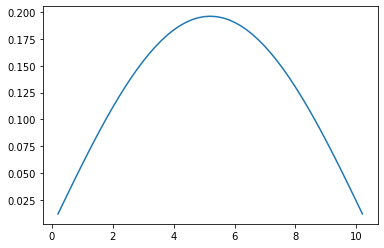

In [5]:
fig, ax = plt.subplots()
for ilm, (l,m) in enumerate(prop.lm):
    ax.plot(prop.r_arr, wf[ilm].real)

#### Analytical solution

In [6]:
from tdse.analytic import spherical_jn_zeros

jl_zero_1 = spherical_jn_zeros(0, 1)

In [7]:
from scipy.special import spherical_jn

R00 = spherical_jn(0, (jl_zero_1 / prop.r_max) * prop.r_arr)
g00 = prop.r_arr * R00
prop.wf_class.normalize(g00, prop.dr)

#### Comparison : analytical - numerical

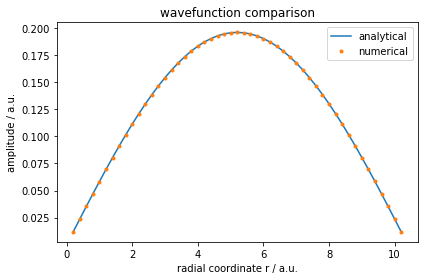

In [8]:
fig, ax = plt.subplots()

ax.plot(prop.r_arr, g00.real, label='analytical')
ax.plot(prop.r_arr, wf[0].real, '.', label='numerical')

ax.legend()
ax.set_xlabel("radial coordinate r / a.u.")
ax.set_ylabel("amplitude / a.u.")
ax.set_title("wavefunction comparison")
fig.tight_layout()

# fig.savefig("state-analytical-comparison-test-1.png")

#### Evalaute the raidal function $R_{lm}(r,t) \equiv \frac{1}{r}g_{lm}(r,t)$

In [9]:
Rm = wf[0,:] / prop.r_arr

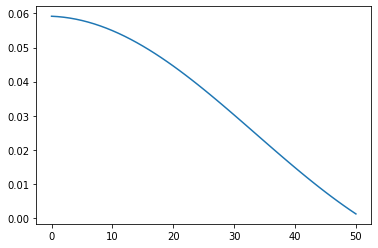

In [10]:
fig, ax = plt.subplots()
ax.plot(Rm.real)

# Real Propagation

In [11]:
dt, Niter, Nt_per_iter = 0.05, 32, 101
t_arr = dt * Nt_per_iter * np.arange(Niter)

In [12]:
wf = np.empty_like(wf_t0, dtype=np.complex)
wf[:] = wf_t0
wf_t = np.empty((Niter,)+wf_t0.shape, dtype=np.complex)
wf_t[0] = wf
for it in range(Niter-1):
    prop.propagate(wf, dt, Nt=Nt_per_iter)
    wf_t[it+1] = wf

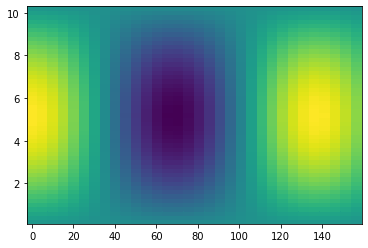

In [13]:
from vis.plot import construct_catesian_mesh_for_pcolormesh
t_cmesh, r_cmesh = construct_catesian_mesh_for_pcolormesh(t_arr, prop.r_arr)

fig, ax = plt.subplots()
ax.pcolormesh(t_cmesh, r_cmesh, wf_t[:,0,:].real)